In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# read the dataset
train = pd.read_csv('/kaggle/input/game-reviews/train.csv')
validation = pd.read_csv('/kaggle/input/game-reviews/validation.csv')
test = pd.read_csv('/kaggle/input/game-reviews/test.csv')

In [4]:
train.shape, validation.shape, test.shape

((17877, 5), (3831, 5), (3831, 5))

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import re

def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return []
    
    # Keep only letters and whitespaces
    pattern = f"[a-zA-Z\s]"
    text = ''.join(re.findall(pattern, text))
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
#     tokens = ' '.join(tokens)
    
    return tokens


In [7]:
#apply the preprocess text to 
train['user_review'] = train['user_review'].apply(preprocess_text)
validation['user_review'] = validation['user_review'].apply(preprocess_text)
test['user_review'] = test['user_review'].apply(preprocess_text)

In [8]:
#check the head of train data
train.head()

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0


In [9]:
def build_vocabulary(reviews):
    vocab = {}
    index = 1  # Start indexing from 1; reserve 0 for padding
    for review in reviews:
        for word in review:
            if word not in vocab:
                vocab[word] = index
                index += 1
    return vocab

In [ ]:
"""train['user_review']=train['user_review'].apply(str)
validation['user_review']=validation['user_review'].apply(str)
test['user_review']=test['user_review'].apply(str)"""

In [10]:
# Concatenate all reviews to build the vocabulary
all_reviews = train['user_review'].tolist() + validation['user_review'].tolist() + test['user_review'].tolist()
vocab = build_vocabulary(all_reviews)
print("Vocabulary Length:", len(vocab))

Vocabulary Length: 104326


In [11]:
#Indexing reviews based on the vocabulary
def index_and_pad_reviews(reviews, vocab, max_length=100):
    """Index and pad tokenized reviews to a fixed length."""
    indexed_reviews = []
    for review in reviews:
        indexed_review = [vocab.get(word, 0) for word in review]  # Use vocab.get to handle unknown words
        # Truncate if review length exceeds max_length
        truncated_review = indexed_review[:max_length]
        # Pad review with zeros if it's shorter than max_length
        padded_review = truncated_review + [0] * (max_length - len(truncated_review))
        indexed_reviews.append(padded_review)
    return indexed_reviews

In [12]:
#converting dataframe to list
train_review = train['user_review'].tolist()
test_review = test['user_review'].tolist()
validation_review = validation['user_review'].tolist()

In [13]:
# Index and pad reviews for each set
train_indexed = index_and_pad_reviews(train_review, vocab)
test_indexed = index_and_pad_reviews(test_review, vocab)
validation_indexed = index_and_pad_reviews(validation_review, vocab)

In [14]:
# Convert indexed reviews back to DataFrame for further use
train['user_review_indexed'] = train_indexed
test['user_review_indexed'] = test_indexed
validation['user_review_indexed'] = validation_indexed

In [15]:
train.head()

,review_id,title,year,user_review,user_suggestion,user_review_indexed
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1,"[46, 84, 84, 84, 85, 57, 86, 10, 58, 82, 87, 1..."
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1,"[1, 2, 102, 82, 103, 12, 104, 29, 105, 57, 58,..."
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1,"[126, 127, 128, 41, 129, 31, 130, 131, 132, 9,..."
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0,"[57, 41, 58, 159, 160, 161, 71, 81, 162, 82, 1..."


In [16]:
for i in range(3):
    print(train.user_review[i], '\n')

['early', 'access', 'reviewvery', 'great', 'shooter', 'that', 'have', 'originality', 'in', 'it', 'but', 'of', 'course', 'some', 'newbies', 'dont', 'understand', 'mechanic', 'of', 'shooting', 'which', 'guns', 'is', 'same', 'or', 'not', 'throught', 'visual', 'look', 'and', 'what', 'to', 'do', 'in', 'rankedbut', 'theres', 'thing', 'that', 'keeps', 'me', 'think', 'how', 'would', 'game', 'evolve', 'sure', 'its', 'still', 'in', 'early', 'access', 'but', 'i', 'think', 'developers', 'need', 'to', 'speed', 'up', 'process', 'of', 'finishing', 'game', 'cuz', 'still', 'comparing', 'to', 'other', 'games', 'this', 'game', 'has', 'low', 'number', 'of', 'community', 'and', 'some', 'things', 'that', 'makes', 'player', 'think', 'that', 'black', 'squad', 'is', 'another', 'copy', 'of', 'csgo', 'and', 'he', 'would', 'not', 'download', 'iti', 'hope', 'you', 'understand', 'my', 'message', 'i', 'really', 'like', 'this', 'game', 'but', 'i', 'dont', 'think', 'it', 'can', 'keep', 'me', 'for', 'a', 'year'] 

['i'

In [17]:
for i in range(3):
    print(train_indexed[:3][i], '\n')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 12, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 9, 33, 34, 35, 6, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 9, 1, 2, 11, 46, 38, 47, 48, 31, 49, 50, 51, 12, 52, 41, 53, 45, 54, 31, 55, 56, 57, 41, 58, 59, 60, 12, 61, 29, 14, 62, 6, 63, 64, 38, 6, 65, 66, 22, 67, 68, 12, 69, 29, 70, 40, 25, 71, 72, 73, 74, 17] 

[46, 84, 84, 84, 85, 57, 86, 10, 58, 82, 87, 12, 88, 31, 89, 90, 74, 91, 25, 92, 93, 94, 95, 96, 29, 97, 98, 99, 22, 100, 101, 84, 31, 57, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

[1, 2, 102, 82, 103, 12, 104, 29, 105, 57, 58, 106, 82, 107, 41, 100, 108, 109, 97, 110, 111, 29, 112, 113, 114, 115, 116, 117, 82, 118, 119, 120, 9, 121, 74, 122, 123, 10, 124, 125, 4, 41, 81, 30, 10, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [18]:
def prepare_data(reviews, labels):
    # Convert the pre-padded reviews into a tensor
    X = torch.tensor(reviews, dtype=torch.float)

    # Convert the labels into a tensor
    y = torch.tensor(labels, dtype=torch.float)

    return X, y

In [19]:
# Prepare data
X_train, y_train = prepare_data(train['user_review_indexed'], train['user_suggestion'])

X_val, y_val = prepare_data(validation['user_review_indexed'], validation['user_suggestion'])

In [20]:
# Create DataLoader
batch_size = 44
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [21]:
# Create DataLoader
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [116]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.5):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Basic RNN layer, without dropout
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.leaky_relu = nn.LeakyReLU()  # Leaky ReLU activation layer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.sigmoid = nn.Sigmoid()  # Sigmoid activation layer

    def forward(self, x):
        # Initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # RNN output
        out, _ = self.rnn(x, h0)
        # Apply Leaky ReLU to the outputs of the RNN layer
        out = self.leaky_relu(out)
        #out = self.dropout(out)
        # Get the last sequence output for classification
        out = out[:, -1, :]
        # Apply the linear layer for the final output
        out = self.fc(out)
        # Apply the sigmoid activation
        #out = self.sigmoid(out)
        return out

In [22]:
import torch
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        #self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        # Embedding layer
        embedded = self.embedding(x)
        # RNN output
        out, _ = self.rnn(embedded)
        # Apply ReLU activation to the output of the RNN
        
        out = out[:, -1, :]
        #out = nn.functional.leaky_relu(out)
        
        out = self.dropout(out)
        # Apply the linear layer for the final output
        out = self.fc(out)
        return out

In [44]:
"""#Define hyperparameters
input_size = 1
hidden_size = 8
output_size = 1
num_layers = 1
learning_rate = 0.0001
num_epochs = 50
vocab_size = len(vocab)
embedding_dim = 16"""

In [23]:
# Initialize model, loss function, and optimizer
model = SentimentRNN(vocab_size=len(vocab), embedding_dim=300, hidden_size=64, output_size=1, num_layers=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [120]:
"""# Initialize model, loss function, and optimizer
model = SentimentRNN(input_size=1, hidden_size=128, output_size=1, num_layers=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)"""

In [24]:
def calculate_accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.unsqueeze(-1).long()
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [25]:
# Assuming you have defined the model, criterion, optimizer, and data loaders

num_epochs = 50  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        # Convert inputs to Long
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Use no_grad context manager for inference
        for inputs, labels in val_loader:
            # Convert inputs to Long
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.long()
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    scheduler.step()
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'rnn_indexing_best_model.pth')  # Save the best model

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 7))
plt.plot(range(1, num_epochs + 1), losses, 'bo-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('rnn_indexing_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

Epoch 1/50, Loss: 0.7011, Val Loss: 0.6855
Epoch 2/50, Loss: 0.6868, Val Loss: 0.6823
Epoch 3/50, Loss: 0.6785, Val Loss: 0.6840
Epoch 4/50, Loss: 0.6746, Val Loss: 0.6839
Epoch 5/50, Loss: 0.6651, Val Loss: 0.6847
Epoch 6/50, Loss: 0.6487, Val Loss: 0.6836
Epoch 7/50, Loss: 0.6435, Val Loss: 0.6817
Epoch 8/50, Loss: 0.6377, Val Loss: 0.6790
Epoch 9/50, Loss: 0.6315, Val Loss: 0.6802
Epoch 10/50, Loss: 0.6248, Val Loss: 0.6800
Epoch 11/50, Loss: 0.6204, Val Loss: 0.6767
Epoch 12/50, Loss: 0.6190, Val Loss: 0.6783
Epoch 13/50, Loss: 0.6176, Val Loss: 0.6786
Epoch 14/50, Loss: 0.6165, Val Loss: 0.6775
Epoch 15/50, Loss: 0.6166, Val Loss: 0.6768
Epoch 16/50, Loss: 0.6155, Val Loss: 0.6758
Epoch 17/50, Loss: 0.6150, Val Loss: 0.6790
Epoch 18/50, Loss: 0.6147, Val Loss: 0.6778
Epoch 19/50, Loss: 0.6151, Val Loss: 0.6754
Epoch 20/50, Loss: 0.6156, Val Loss: 0.6775
Epoch 21/50, Loss: 0.6155, Val Loss: 0.6797
Epoch 22/50, Loss: 0.6137, Val Loss: 0.6795
Epoch 23/50, Loss: 0.6153, Val Loss: 0.68

NameError: name 'plt' is not defined

In [ ]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
test_count = 0

with torch.inference_mode():
    for inputs, labels in test_loader:
        test_outputs = model(inputs)
        test_outputs = test_outputs.squeeze()  # Squeeze the output to match the label's shape
        loss = criterion(test_outputs, labels.float())  # Ensure labels are float
        test_loss += loss.item()
        test_count += 1

average_test_loss = test_loss / test_count  # Calculate average test loss
test_accuracy = calculate_accuracy(test_loader)
print(f'Test Loss: {average_test_loss:.4f} Test Accuracy: {test_accuracy:.4f}')

# **RNN with Word2Vec**

In [8]:
# Fetch embeddings
word2vec_model = Word2Vec(sentences=train.user_review.values.tolist(), 
                          vector_size=100, min_count=1, workers=4)

# Get vocabulary size
vocab_size = len(word2vec_model.wv)
print(vocab_size)

81493


In [9]:
def text_to_embeddings(text, word2vec_model, seq_length):
    embeddings = []
    
    for i, word in enumerate(text):
        if word in word2vec_model.wv:
            if i == seq_length:
                break
            embeddings.append(word2vec_model.wv[word])
        else:
            continue
        
    # Padding the sequences
    if len(embeddings) < seq_length:
        zero_padding = [np.zeros(word2vec_model.vector_size) \
                        for _ in range(seq_length - len(embeddings))]

        embeddings = embeddings + zero_padding

    return embeddings[:seq_length]

In [10]:
# Prepare data
def prepare_data(reviews, labels, word2vec_model):
    X = [text_to_embeddings(review, word2vec_model, 100) for review in reviews]
    X = [torch.tensor(embeddings, dtype=torch.float32) for embeddings in X]
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

In [11]:
# Prepare data
X_train, y_train = prepare_data(train.user_review, train.user_suggestion,
                    word2vec_model)

X_val, y_val = prepare_data(validation.user_review, validation.user_suggestion,
                    word2vec_model)

/tmp/ipykernel_34/5277148.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  X = [torch.tensor(embeddings, dtype=torch.float32) for embeddings in X]


In [13]:
batch_size = 44
# Create DataLoader
train_data = TensorDataset(torch.stack(X_train), y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [14]:
# Create DataLoader
val_data = TensorDataset(torch.stack(X_val), y_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [36]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Basic RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.leaky_relu = nn.LeakyReLU()  # Leaky ReLU activation layer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.sigmoid = nn.Sigmoid()  # Sigmoid activation layer

    def forward(self, x):
        # Initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # RNN output
        out, _ = self.rnn(x, h0)
        # Apply Leaky ReLU to the outputs of the RNN layer
        out = self.leaky_relu(out)
        out = self.dropout(out)
        # Get the last sequence output for classification
        out = out[:, -1, :]
        # Apply the linear layer for the final output
        out = self.fc(out)
        # Apply the sigmoid activation
        #out = self.sigmoid(out)
        return out


In [40]:
# Define hyperparameters
input_size = word2vec_model.vector_size
hidden_size = 256
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64
dropout_rate = 0.5
leaky_relu_slope = 0.1

In [44]:
# Initialize model, loss function, and optimizer
model = SentimentRNN(input_size, hidden_size, output_size, dropout_rate).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [21]:
def calculate_accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

Epoch 1/50, Loss: 0.6908, Val Loss: 0.6831
Epoch 2/50, Loss: 0.6816, Val Loss: 0.6811
Epoch 3/50, Loss: 0.6773, Val Loss: 0.6773
Epoch 4/50, Loss: 0.6774, Val Loss: 0.6861
Epoch 5/50, Loss: 0.6833, Val Loss: 0.6843
Epoch 6/50, Loss: 0.6633, Val Loss: 0.6313
Epoch 7/50, Loss: 0.6838, Val Loss: 0.6804
Epoch 8/50, Loss: 0.6706, Val Loss: 0.6581
Epoch 9/50, Loss: 0.6650, Val Loss: 0.6235
Epoch 10/50, Loss: 0.6396, Val Loss: 0.6574
Epoch 11/50, Loss: 0.6456, Val Loss: 0.6348
Epoch 12/50, Loss: 0.6251, Val Loss: 0.6186
Epoch 13/50, Loss: 0.6321, Val Loss: 0.6151
Epoch 14/50, Loss: 0.6419, Val Loss: 0.6627
Epoch 15/50, Loss: 0.6351, Val Loss: 0.6045
Epoch 16/50, Loss: 0.6203, Val Loss: 0.6128
Epoch 17/50, Loss: 0.6213, Val Loss: 0.6239
Epoch 18/50, Loss: 0.6499, Val Loss: 0.6652
Epoch 19/50, Loss: 0.6617, Val Loss: 0.6833
Epoch 20/50, Loss: 0.6790, Val Loss: 0.6775
Epoch 21/50, Loss: 0.6769, Val Loss: 0.6769
Epoch 22/50, Loss: 0.6737, Val Loss: 0.6783
Epoch 23/50, Loss: 0.6739, Val Loss: 0.67

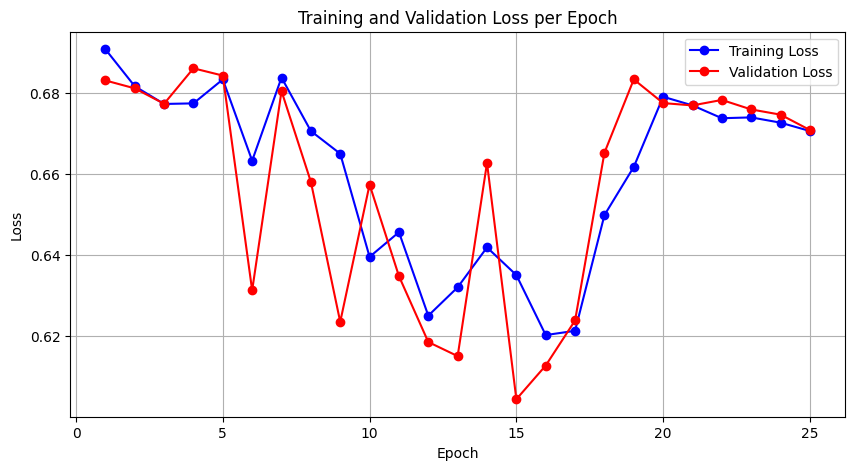

Best Model Training Accuracy: 68.96011635061811%
Best Model Validation Accuracy: 68.8593056643174%


In [45]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 50  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 10  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'rnn_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('rnn_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

# **Bidirectional RNN with MultiLayer**

In [46]:
# Define num_layers
num_layers = 2

In [60]:
class SentimentBiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.5):
        super(SentimentBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Using RNN for the recurrent layer
        self.bi_rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        # Doubling the output size because of bidirectionality
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Initialize hidden state for RNN
        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the RNN
        out, _ = self.bi_rnn(x, h0)
        # Apply Leaky ReLU activation
        out = nn.functional.leaky_relu(out)
        out = self.dropout(out)
        # Get the last time step's output for the fully connected layer
        out = self.fc(out[:, -1, :])
        # Apply sigmoid to the output layer
        #out = torch.sigmoid(out)
        return out

In [71]:
# Define hyperparameters
input_size = word2vec_model.vector_size
hidden_size = 256
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64
dropout_rate = 0.5
leaky_relu_slope = 0.1

In [73]:
# Initialize model, loss function, and optimizer
model = SentimentBiRNN(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

Epoch 1/50, Loss: 0.6866, Val Loss: 0.6815
Epoch 2/50, Loss: 0.6801, Val Loss: 0.6772
Epoch 3/50, Loss: 0.6808, Val Loss: 0.6796
Epoch 4/50, Loss: 0.6694, Val Loss: 0.6781
Epoch 5/50, Loss: 0.6758, Val Loss: 0.6759
Epoch 6/50, Loss: 0.6730, Val Loss: 0.6743
Epoch 7/50, Loss: 0.6713, Val Loss: 0.6719
Epoch 8/50, Loss: 0.6654, Val Loss: 0.6458
Epoch 9/50, Loss: 0.6520, Val Loss: 0.6708
Epoch 10/50, Loss: 0.6748, Val Loss: 0.6843
Epoch 11/50, Loss: 0.6820, Val Loss: 0.6842
Epoch 12/50, Loss: 0.6812, Val Loss: 0.6841
Epoch 13/50, Loss: 0.6793, Val Loss: 0.6840
Epoch 14/50, Loss: 0.6783, Val Loss: 0.6830
Epoch 15/50, Loss: 0.6766, Val Loss: 0.6792
Epoch 16/50, Loss: 0.6637, Val Loss: 0.6472
Epoch 17/50, Loss: 0.6654, Val Loss: 0.6879
Epoch 18/50, Loss: 0.6816, Val Loss: 0.6851
Early stopped at 18
Lowest Validation Loss: 0.6458 at Epoch 8


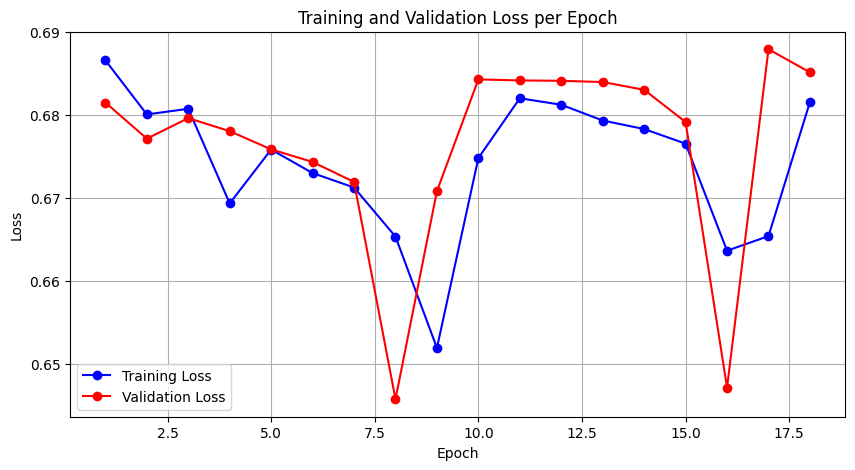

Best Model Training Accuracy: 59.607316663869774%
Best Model Validation Accuracy: 60.219263899765075%


In [74]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 50  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 10  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'bidirectional_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('bidirectional_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

# **Bidirectional GRU**

In [15]:
class SentimentGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.5, leaky_relu_slope=0.1):
        super(SentimentGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, 
                          bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Output size is doubled because of bidirectionality
    
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the GRU
        out, _ = self.gru(x, h0)
        # Apply Leaky ReLU activation
        out = nn.functional.leaky_relu(out)
        # Apply dropout
        out = self.dropout(out)
        # Use only the last output for the fully connected layer
        out = self.fc(out[:, -1, :])
        # Apply sigmoid to the output layer
        #out = torch.sigmoid(out)
        return out

In [73]:
# Define hyperparameters
input_size = word2vec_model.vector_size
hidden_size = 60
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64
dropout_rate = 0.5
leaky_relu_slope = 0.1

In [76]:
# Initialize model, loss function, and optimizer
model = SentimentGRU(input_size, hidden_size, output_size, num_layers, dropout_rate, leaky_relu_slope).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/15, Loss: 0.6832, Val Loss: 0.6833
Epoch 2/15, Loss: 0.6618, Val Loss: 0.5864
Epoch 3/15, Loss: 0.6536, Val Loss: 0.6561
Epoch 4/15, Loss: 0.6263, Val Loss: 0.6657
Epoch 5/15, Loss: 0.5778, Val Loss: 0.5227
Epoch 6/15, Loss: 0.5963, Val Loss: 0.6640
Epoch 7/15, Loss: 0.5947, Val Loss: 0.5334
Epoch 8/15, Loss: 0.5083, Val Loss: 0.4684
Epoch 9/15, Loss: 0.4689, Val Loss: 0.4448
Epoch 10/15, Loss: 0.4427, Val Loss: 0.4334
Epoch 11/15, Loss: 0.4266, Val Loss: 0.4156
Epoch 12/15, Loss: 0.4051, Val Loss: 0.3980
Epoch 13/15, Loss: 0.3928, Val Loss: 0.4088
Epoch 14/15, Loss: 0.3768, Val Loss: 0.3953
Epoch 15/15, Loss: 0.3605, Val Loss: 0.3892
Lowest Validation Loss: 0.3892 at Epoch 15


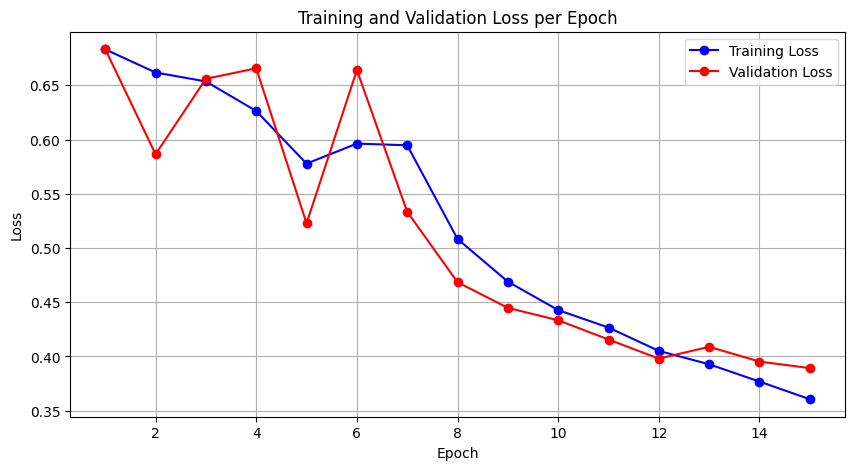

Best Model Training Accuracy: 86.04911338591486%
Best Model Validation Accuracy: 82.43278517358392%


In [77]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 15  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 3  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'bi_gru_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('bi_gru_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

# **Bidirectional LSTM**

In [44]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.5, leaky_relu_slope=0.1):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.leaky_relu_slope = leaky_relu_slope

        # # Create LSTM layers with nn.LSTM

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # Define dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer (output size is doubled for bidirectionality)
        self.fc = nn.Linear(hidden_size * 2, output_size)

        # Sigmoid activation for output layer
        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)

        outputs, _ = self.lstm(x, (h_0, c_0))
        
        outputs = F.leaky_relu(outputs, negative_slope=self.leaky_relu_slope)  # Leaky ReLU activation

        # Apply dropout and fully connected layer
        outputs = self.dropout(outputs)
        out = self.fc(outputs[:, -1, :])

        # Sigmoid activation for output
        #out = self.sigmoid(out)
        return out


In [62]:
# Define hyperparameters
input_size = word2vec_model.vector_size
hidden_size = 60
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64
dropout_rate = 0.1
leaky_relu_slope = 0.1

In [63]:
# Initialize model, loss function, and optimizer
model = SentimentLSTM(input_size, hidden_size, output_size, num_layers, dropout_rate, leaky_relu_slope).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/15, Loss: 0.6801, Val Loss: 0.6862
Epoch 2/15, Loss: 0.6557, Val Loss: 0.6844
Epoch 3/15, Loss: 0.6785, Val Loss: 0.6819
Epoch 4/15, Loss: 0.6328, Val Loss: 0.6439
Epoch 5/15, Loss: 0.5917, Val Loss: 0.5588
Epoch 6/15, Loss: 0.5338, Val Loss: 0.5267
Epoch 7/15, Loss: 0.4912, Val Loss: 0.4832
Epoch 8/15, Loss: 0.4543, Val Loss: 0.4491
Epoch 9/15, Loss: 0.4185, Val Loss: 0.4388
Epoch 10/15, Loss: 0.3920, Val Loss: 0.4204
Epoch 11/15, Loss: 0.3736, Val Loss: 0.4133
Epoch 12/15, Loss: 0.3545, Val Loss: 0.4072
Epoch 13/15, Loss: 0.3344, Val Loss: 0.4210
Epoch 14/15, Loss: 0.3143, Val Loss: 0.4193
Epoch 15/15, Loss: 0.3005, Val Loss: 0.4292
Early stopped at 15
Lowest Validation Loss: 0.4072 at Epoch 12


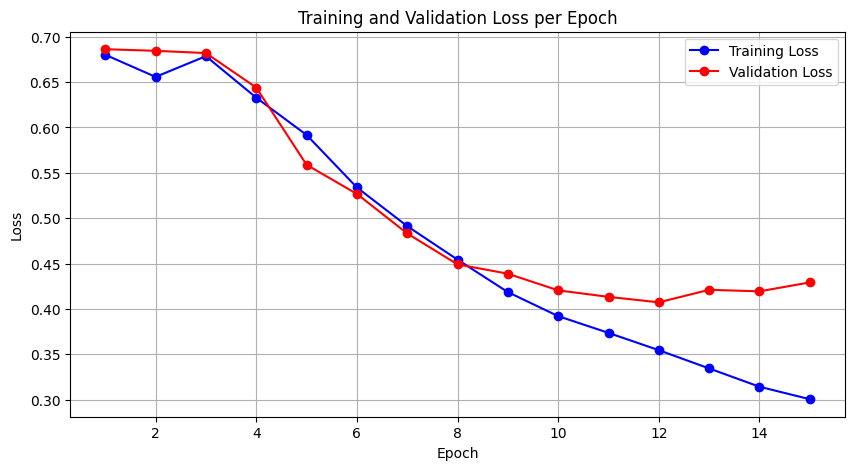

Best Model Training Accuracy: 85.6743301448789%
Best Model Validation Accuracy: 81.64969981728008%


In [64]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 15  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 3  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'bi_lstm_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('bi_lstm_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

In [ ]:
#Best Model Training Accuracy: 85.6743301448789%
#Best Model Validation Accuracy: 81.64969981728008%

# **Performance on Test Data**

In [78]:
X_test, y_test = prepare_data(test.user_review, test.user_suggestion,
                    word2vec_model)

In [85]:
test_data = TensorDataset(torch.stack(X_test), y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [86]:
# Initialize model, loss function, and optimizer
model = SentimentGRU(input_size, hidden_size, output_size, num_layers, dropout_rate, leaky_relu_slope).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [88]:
model.load_state_dict(torch.load('bi_gru_best_model.pth'))

<All keys matched successfully>

In [89]:
# model.load_state_dict(torch.load('bi_gru_best_model.pth'))
test_accuracy = calculate_accuracy(test_loader)
print(f'Test Accuracy: {test_accuracy}%')

Test Accuracy: 81.93683111459148%


In [90]:
# Initialize model, loss function, and optimizer
model = SentimentLSTM(input_size, hidden_size, output_size, num_layers, dropout_rate, leaky_relu_slope).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [91]:
model.load_state_dict(torch.load('bi_lstm_best_model.pth'))

<All keys matched successfully>

In [92]:
# model.load_state_dict(torch.load('bi_gru_best_model.pth'))
test_accuracy = calculate_accuracy(test_loader)
print(f'Test Accuracy: {test_accuracy}%')

Test Accuracy: 81.41477421038893%
